# Inclusive UE

In [1]:
from array import array
import itertools
import time
import math

import sys
#####For NERSC:####
#sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

#import astroML.plotting as aml
#import iminuit
import pandas as pd
import root_pandas as rpd
from root_pandas import read_root
import ROOT
from ROOT import TH1D
from ROOT import SetOwnership
from matplotlib.ticker import NullFormatter
from ROOT import TLatex

from matplotlib import pyplot as plt
%matplotlib inline    

from default_values import *
import default_values
reload(default_values)

from Statistics import *
import Statistics
reload(Statistics)

from functions_root_nparray import *
import functions_root_nparray
reload(functions_root_nparray)

Welcome to JupyROOT 6.14/04
../InputData/zT_Rebin_9_006zT06zT/pp_SE_L0_Correlation_GMB_Ratio.root
pp File: ../InputData/zT_Rebin_9_006zT06zT/pp_SE_L0_Correlation_GMB_Ratio.root
p-Pb File: ../InputData/zT_Rebin_9_006zT06zT/pPb_SE_L0_Correlation_GMB_Ratio.root
../InputData/zT_Rebin_9_006zT06zT/pp_SE_L0_Correlation_GMB_Ratio.root
pp File: ../InputData/zT_Rebin_9_006zT06zT/pp_SE_L0_Correlation_GMB_Ratio.root
p-Pb File: ../InputData/zT_Rebin_9_006zT06zT/pPb_SE_L0_Correlation_GMB_Ratio.root


<module 'functions_root_nparray' from 'functions_root_nparray.pyc'>

In [2]:
N_Bins = 6
bins = np.geomspace(0.06, 0.6, num=N_Bins+1)
for ibin in bins:
    if ibin == bins[0]:
        print"[%1.3f,"%(ibin),
        
    elif ibin == bins[N_Bins]:
        print"%1.3f]"%(ibin),
        
    else:
        print "%1.3f,"%(ibin),
print("")

[0.060, 0.088, 0.129, 0.190, 0.278, 0.409, 0.600] 


0.535827209253
0.0386182398675
9.46305649534
11.3188096455

0.133280 0.169190 0.203815 0.236933 0.268355 0.297931 0.325545 0.351121 0.374621 0.396038 0.415403 0.432770 0.448222 0.461860 0.473799 0.484169 0.493103 0.500738 0.507211 0.512655 0.517197 0.520956 0.524041 0.526554 0.528584 0.530211 0.531505 0.532525 0.533323 0.533942 0.534418 0.534782 0.535058 0.535265 0.535420 0.535534 0.535618 0.535679 0.535723 0.535754 


 FCN=0.859434 FROM MIGRAD    STATUS=CONVERGED     215 CALLS         216 TOTAL
                     EDM=2.20419e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.35829e-01   3.86179e-02   1.76040e-05   9.74606e-03
   2  p1           9.46300e+00   2.13492e+00   4.99057e-04  -4.76701e-04
   3  p2           1.13188e+01   4.23558e+00   8.63297e-04  -1.35678e-04
 FCN=0.859434 FROM MIGRAD    STATUS=CONVERGED      38 CA

Info in <TCanvas::Print>: pdf file pics/Err_Function_Purity.pdf has been created


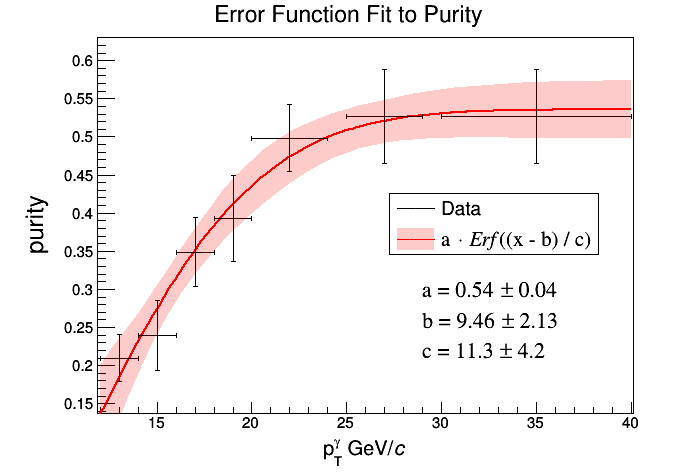

In [5]:
from ROOT import TF1
from ROOT import TMath

pGeV_Edges = np.asarray([12,14,16,18,20,25,30,40,50])
pGeV_Centers = (pGeV_Edges[1:] + pGeV_Edges[:-1]) / 2
pGeV_Widths = [(j-i)/2 for i, j in zip(pGeV_Edges[:-1], pGeV_Edges[1:])]
#print(pGeV_Widths)

Purity = [0.21,0.24,0.349,0.393,0.498,0.527,0.527,0.527] #8
Purity_errors = [0.031,0.046,0.045,0.056,0.044,0.062,0.062,0.062,0.062]

#Fill a TGraph with Purity Information
Purity_Graph = ROOT.TGraphErrors()
for izt in range (len(Purity)):

    Purity_Graph.SetPoint(izt,pGeV_Centers[izt],Purity[izt])
    Purity_Graph.SetPointError(izt,pGeV_Widths[izt],Purity_errors[izt])
    
    #Purity_Graph.SetPointError(izt,0,Purity_errors[izt])
    #Purity_Graph.SetPoint(izt,pGeV_Edges[izt],Purity[izt])

#Define your function and set parameters (notice use of string)
func = TF1("func",'[0]*TMath::Erf((x-[1])/[2])',12,40)
func.SetParameter(0,0.5)
func.SetParameter(1,0.5)
func.SetParameter(2,1.0)

Purity_Graph.Fit("func","S")

Fit_Band = ROOT.TGraphErrors(len(Purity));
pGeV_Edges_3 = np.linspace(12,40,40)
for i in range(len(pGeV_Edges_3)):
        Fit_Band.SetPoint(i, pGeV_Edges_3[i], 0)
(ROOT.TVirtualFitter.GetFitter()).GetConfidenceIntervals(Fit_Band,0.68)
    
c = ROOT.TCanvas()
c.SetRightMargin(0.09);
c.SetLeftMargin(0.14);
c.SetBottomMargin(0.125);
c.SetTopMargin(0.08)

Purity_Graph.SetTitle("Error Function Fit to Purity")
#Purity_Graph.SetMarkerStyle(8)
Purity_Graph.SetMarkerSize(0.5)
Purity_Graph.SetMarkerColorAlpha(4,1.0)
Purity_Graph.Draw("AP")

x = Purity_Graph.GetXaxis()
x.SetRangeUser(12.0,40.0)
x.SetTitle("p_{T}^{#gamma} GeV/#it{c}")
x.SetTitleSize(0.045)
x.SetTitleOffset(1.15)
x.CenterTitle()

y = Purity_Graph.GetYaxis()
y.SetTitleSize(0.055)
y.SetTitle("purity")
y.SetTitleOffset(1.0)
y.CenterTitle()

fit = Purity_Graph.Fit("func","S")
print(fit)
print fit.Parameters()[0]
print fit.ParError(0)
print fit.Parameters()[1]
print fit.Parameters()[2]

latex = ROOT.TLatex();
latex.SetTextSize(0.05);
latex.SetTextAlign(13);  #align at top
#latex.DrawLatex(25,.35,"#font[12]{a #times Erf((x - b) / c)}")
latex.DrawLatex(29,.31,"#font[132]{a = %1.2f #pm %1.2f}"%(fit.Parameters()[0],fit.ParError(0)))
latex.DrawLatex(29,.27,"#font[132]{b = %1.2f #pm %1.2f}"%(fit.Parameters()[1],fit.ParError(1)))
latex.DrawLatex(29,.23,"#font[132]{c = %1.1f #pm %1.1f}"%(fit.Parameters()[2],fit.ParError(2)))

legend = ROOT.TLegend(0.56,0.46,0.86,0.59)
#legend = ROOT.TLegend(0.18,0.88,0.4,0.75)
legend.AddEntry(Purity_Graph,"Data")
legend.AddEntry(Fit_Band,"#scale[1.1]{#font[132]{a #upoint #it{Erf}((x - b) / c)}}")
legend.Draw()

Fit_Band.SetLineColor(ROOT.kRed);
Fit_Band.SetFillColorAlpha(ROOT.kRed,0.2)
Fit_Band.Draw("same3");
c.Draw()
c.SaveAs("pics/Err_Function_Purity.pdf")

print("")
fit_vals = []
for x in pGeV_Edges_3:
    Err_val = fit.Parameters()[0]*TMath.Erf((x-fit.Parameters()[1])/fit.Parameters()[2])
    fit_vals.append(Err_val)
    print("%1.6f"%(Err_val)),
print("\n")
print("")

0.539705367776
8.88588077192
12.2892938905


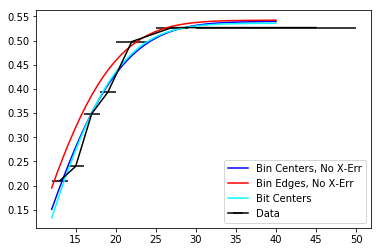

In [48]:

#print("pT GeV/c:  "),
#for i in range(len(pGeV_Edges_3)):
    #print(pGeV_Edges_3[i]),
#print("")

fit_vals_New = []
fit_vals = []
fit_vals_Old = []
print fit.Parameters()[0]
print fit.Parameters()[1]
print fit.Parameters()[2]


#print("Purity Val:"),
for x in pGeV_Edges_3:
    Err_val_Old = 0.542257*TMath.Erf((x-8.09242)/11.8085)
    Err_val = 0.539705386488*TMath.Erf((x-8.88586771026)/12.2892853578)
    Err_val_New = 0.535827193204*TMath.Erf((x-9.46314584468)/11.3184942653)
    
    fit_vals.append(Err_val)
    fit_vals_Old.append(Err_val_Old)
    fit_vals_New.append(Err_val_New)
    #print("%1.6f"%(Err_val)),
#print("")

fit_errors = []
#print("P Uncert.: "),
for i in range(len(pGeV_Edges_3)):
    fit_errors.append(Fit_Band.GetErrorY(i))
    #print("%1.2f"%(Fit_Band.GetErrorY(i))),
#print("\n")

plt.plot(pGeV_Edges_3,fit_vals,color="blue",label="Bin Centers, No X-Err")
plt.plot(pGeV_Edges_3,fit_vals_Old,color="red",label="Bin Edges, No X-Err")
plt.plot(pGeV_Edges_3,fit_vals_New,color="cyan",label="Bit Centers")
plt.errorbar(pGeV_Centers,Purity,xerr=pGeV_Widths,color="k",label="Data")
plt.legend()

In [5]:
#Old Purity Val: 0.195322 0.257569 0.313537 0.362468 0.404063 0.438445 0.466078 0.487672 0.504081 0.516205 0.524915 0.531000 0.535132 0.537862 0.539615 0.540709 0.541374 0.541766 0.541991 0.542117 0.542185
#New Purity Val: 0.152395 0.214219 0.271331 0.322836 0.368178 0.407144 0.439834 0.466605 0.488008 0.504711 0.517436 0.526900 0.533771 0.538641 0.542010 0.544285 0.545785 0.546751 0.547358 0.547730 0.547952 
#P Uncert :      0.03 0.02 0.02 0.02 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.03 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04

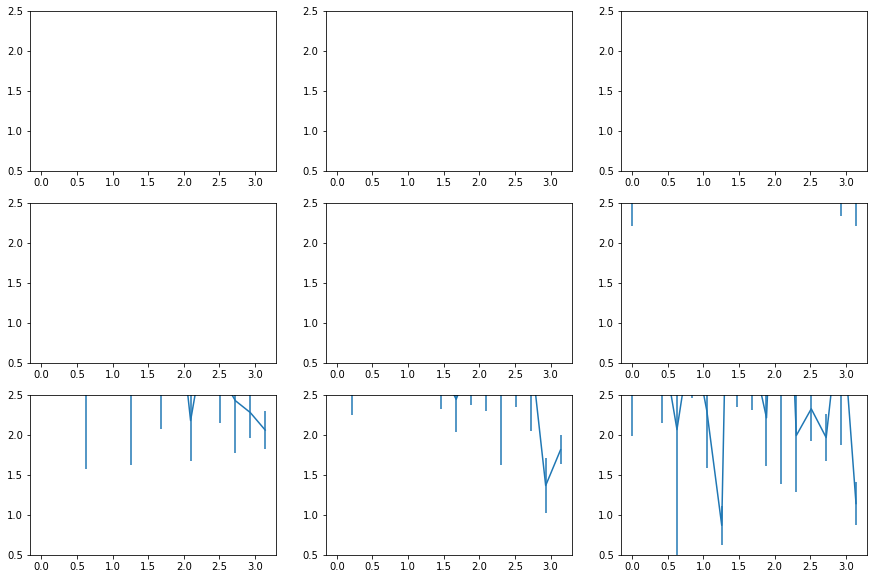

In [6]:
#File1 = "../InputData/pp_GMB_RATIO_COMBINED_OLD.root"
#File2 = "../InputData/05zT/pp_GMB_RATIO_COMBINED_NEW.root"

#File1 = "../InputData/05zT/13f_0GeVTracks_Mixed_300_Correlation_Lambda.root"
#File2 = "../InputData/1zT/13f_0GeVTrack_paired_0GeVTracks_Correlation_Lambda_0_to_300.root"

#File1 = "../InputData/05zT/13f_SE_L0_Correlation.root"
#File2 = "../InputData/1zT/13f_SE_L0_Correlation.root"

#File1="../InputData/13f_SE_L0_Correlation15_min.root"
#File2="../InputData/13f_SE_L0_Correlation12_min.root"

#File1="../InputData/pT_Rebin_4_Weights/13f_0GeVTracks_Mixed_300_Correlation_Lambda.root"
#File2="../InputData/pT_Rebin_4_Weights/13f_0GeVTracks_Mixed_300_Correlation_Lambda.root"
#File1="../InputData/pT_Rebin_1_pDevPlus/13f_0GeVTracks_Mixed_300_Correlation_Lambda.root"
#File2="../InputData/pT_Rebin_1/13f_0GeVTracks_Mixed_300_Correlation_Lambda.root"
File1="../InputData/pT_Rebin_1_pDevNONE/pPb_SE_L0_Correlatioooon_GMB_Ratio.root"
File2="../InputData/pT_Rebin_1_pDevNONE/pPb_SE_L0_Correlation_GMB_Ratio.root"


File1=pPb_File
File2=pp_File

#File1="../InputData/05zT/13f_SE_L0_Correlation.root"
#File2 = "../InputData/pT_Rebin_4/13f_SE_L0_Correlation.root"

file1 = ROOT.TFile(File1)
file2 = ROOT.TFile(File2)

for ipt in range (N_pT_Bins):
    fig = plt.figure(figsize=(15,10))

    for izt in range (0,NzT-ZT_OFF_PLOT):
        ax = fig.add_subplot(3,3,izt+1)

        Histo1 = file1.Get("DNN1_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f"%(pTbins[ipt],pTbins[ipt+1],zTbins[izt]*100,zTbins[izt+1]*100))
        #print(("Correlation__pT%1.0f_%1.0f__zT%1.0f_%1.0f"%(pTbins[ipt],pTbins[ipt+1],zTbins[izt]*100,zTbins[izt+1]*100)))
        Histo2 = file2.Get("DNN2_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f"%(pTbins[ipt],pTbins[ipt+1],zTbins[izt]*100,zTbins[izt+1]*100))


        HISTO1 = Histo1.ProjectionX("Sig_Phi",0,-1)
        HISTO2 = Histo2.ProjectionX("Bkg_Phi",0,-1)

        HISTO1.Divide(HISTO2)

        Signal = root_numpy.hist2array(HISTO1)
        Background = root_numpy.hist2array(HISTO2)

        N_Bins = HISTO1.GetSize() - 2 #Ignero under/overflow
        S_Error = np.zeros(N_Bins)
        B_Error = np.zeros(N_Bins)
        for i in range(1,N_Bins+1):
            S_Error[i-1] = HISTO1.GetBinError(i)
            B_Error[i-1] = HISTO2.GetBinError(i)

        Corr_Axis = np.linspace(0,3.14159,N_Bins)

        #print(HISTO1)


        plt.errorbar(Corr_Axis,Signal,yerr = S_Error,label="Signal Clusters ($\lambda^{2}_{0}$ < 0.4)")
        #plt.errorbar(Corr_Axis,Background,yerr = B_Error,label="Signal Clusters ($\lambda^{2}_{0}$ < 0.4)")

        plt.ylim(0.5,2.5)
#plt.title(r"Isolated Cluster $p_{\mathrm{T}}$ Distribution  $\lambda$")
#plt.ylim(0.5,0.58)
#plt.ylim(1.9,2.0)


0.513506511244
8.93208262157
16.3546687477
0.583623215723
6.01093079864
19.3085260578
 FCN=0.461499 FROM MIGRAD    STATUS=CONVERGED      82 CALLS          83 TOTAL
                     EDM=6.31518e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.13506e-01   1.52721e-02   4.30927e-06  -2.91794e-03
   2  p1           8.93206e+00   1.10566e+00   2.21257e-04  -6.29278e-04
   3  p2           1.63546e+01   2.35090e+00   3.43740e-04  -7.11200e-04
 FCN=0.461499 FROM MIGRAD    STATUS=CONVERGED      36 CALLS          37 TOTAL
                     EDM=5.64258e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.13507e-01   1.52723e-02   4.30904e-06  -4.01985e-02
   2  p1          

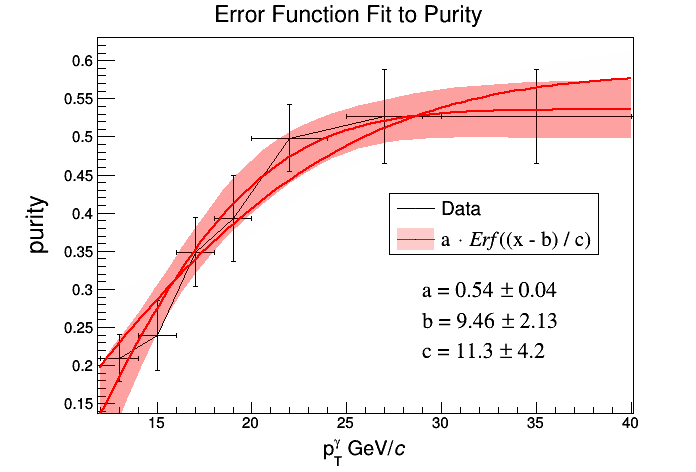

In [7]:
from ROOT import TF1
from ROOT import TMath

#Define pT Bins and Range
pGeV_Edges_3 = np.linspace(12,40,29)

#Define your function and set parameters (notice use of string)ee
Purity_Graph.Draw("")
Fit_Band.SetLineColor(ROOT.kRed);
Fit_Band.SetFillColorAlpha(ROOT.kRed,0.2)
Fit_Band.Draw("same3");

#Fill a TGraph with Purity Information
Purity_Graph_fit_bottom = ROOT.TGraphErrors()
for izt in range (len(pGeV_Edges_3)):
    Purity_Graph_fit_bottom.SetPoint(izt,pGeV_Edges_3[izt],fit_vals[izt]-fit_errors[izt])
    Purity_Graph_fit_bottom.SetPointError(izt,0,fit_errors[izt])
Purity_Graph_fit_bottom.Fit("func","S")
Purity_Graph_fit_bottom.SetFillColorAlpha(ROOT.kRed,0.0)
Purity_Graph_fit_bottom.Draw("same3")
fit = Purity_Graph_fit_bottom.Fit("func","S")
print fit.Parameters()[0]
print fit.Parameters()[1]
print fit.Parameters()[2]
fit.Draw("same")

#Fill a TGraph with Purity Information
Purity_Graph_fit_bottom = ROOT.TGraphErrors()
for izt in range (len(pGeV_Edges_3)):
    Purity_Graph_fit_bottom.SetPoint(izt,pGeV_Edges_3[izt],fit_vals[izt]+fit_errors[izt])
    Purity_Graph_fit_bottom.SetPointError(izt,0,fit_errors[izt])
Purity_Graph_fit_bottom.Fit("func","S")
Purity_Graph_fit_bottom.SetFillColorAlpha(ROOT.kRed,0.0)
Purity_Graph_fit_bottom.Draw("same3")
fit = Purity_Graph_fit_bottom.Fit("func","S")
print fit.Parameters()[0]
print fit.Parameters()[1]
print fit.Parameters()[2]
fit.Draw("same")
c.Draw()

In [8]:
def GetCorrelation_Npairs(filename,pt_min,pt_max, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f'
                        %(pt_min[ipt],pt_max,100*zTbins[izt],100*zTbins[izt+1]))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pt_min,pt_max,100*zTbins[izt],100*zTbins[izt+1]))
        
    N_Pairs = histo2D.GetEntries()
    return N_Pairs

In [9]:
reload(default_values)
from default_values import *

../InputData/zT_Rebin_9_006zT06zT/pp_SE_L0_Correlation_GMB_Ratio.root
pp File: ../InputData/zT_Rebin_9_006zT06zT/pp_SE_L0_Correlation_GMB_Ratio.root
p-Pb File: ../InputData/zT_Rebin_9_006zT06zT/pPb_SE_L0_Correlation_GMB_Ratio.root


In [10]:
print(Files)
print(pTbins)

['../InputData/zT_Rebin_9_006zT06zT/pp_SE_L0_Correlation_GMB_Ratio.root', '../InputData/zT_Rebin_9_006zT06zT/pPb_SE_L0_Correlation_GMB_Ratio.root']
[12, 40]


In [11]:
def Get_NTriggers(filename,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "Inclusive"):
        ntrig_histo = file.Get('N_Inclusive_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    elif (Signal_DNN == "Isolated"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
        
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

In [12]:
zT_Sums = np.zeros((2,NzT))
counter = 0
for file,system in zip(Files,Systems):
    print("                                   [%s]\n"%(system))
    print("zT Bins:           "),
    for izt in range(NzT):
        print(r"%1.2f-%1.2f,"%(zTbins[izt],zTbins[izt+1])),
        for ipt in range (N_pT_Bins):
            n_pairs = GetCorrelation_Npairs(file,pTbins[ipt],pTbins[ipt+1],izt,True)
            if math.isnan(n_pairs):
                continue
            zT_Sums[counter][izt]+= n_pairs
        
    print("\n")
    for ipt in range(N_pT_Bins):
        print("pT Range: %1.1f-%1.1f"%(pTbins[ipt],pTbins[ipt+1])),
        for izt in range (NzT):
            print("   %1.1f,"%(GetCorrelation_Npairs(file,pTbins[ipt],pTbins[ipt+1],izt,True))),
        print("\n")

    print("%s sum = "%(system)),
    for izt in range (NzT):
        print("%1.0f,  "%(zT_Sums[counter][izt])),
    print("\n")
    counter+=1


                                   [pp]

zT Bins:            0.06-0.08, 0.08-0.10, 0.10-0.13, 0.13-0.17, 0.17-0.22, 0.22-0.28, 0.28-0.36, 0.36-0.47, 0.47-0.60, 

pT Range: 12.0-40.0    13261.0,    11380.6,    7809.8,    5433.8,    3374.7,    1879.2,    1076.1,    622.6,    352.7, 

pp sum =  13261,   11381,   7810,   5434,   3375,   1879,   1076,   623,   353,   

                                   [p-Pb]

zT Bins:            0.06-0.08, 0.08-0.10, 0.10-0.13, 0.13-0.17, 0.17-0.22, 0.22-0.28, 0.28-0.36, 0.36-0.47, 0.47-0.60, 

pT Range: 12.0-40.0    50941.3,    42426.1,    29543.5,    19010.0,    10856.5,    5682.5,    2821.1,    1248.3,    641.0, 

p-Pb sum =  50941,   42426,   29543,   19010,   10856,   5683,   2821,   1248,   641,   



## 2D PLOTS

In [13]:
from Statistics import *
import Statistics
reload(Statistics)

<module 'Statistics' from 'Statistics.pyc'>

In [14]:
#####Obtains the phi projection within the eta region (|eta|<0.6)#####
def Get2D(filename,prfx,ipt, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)

    eta_max = 1.2 #Assuming symmetric eta range
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-eta_max),Eta_Axis.FindBin(eta_max))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-eta_max),Eta_Axis.FindBin(eta_max))
                                            
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/(2*eta_max))
    
    #per trigger yield
#     ntriggers = Get_NTriggers(filename,ipt, Signal_DNN)
#     if not(ntriggers == None):
#         PhiProjection.Scale(1.0/ntriggers)
    
    file.Close()
    
    Phi_Array = np.zeros(len(delta_phi_centers))
    Phi_Error_Array = np.zeros(len(delta_phi_centers))
    for bin in range(2,9):
        Phi_Array[bin-2] = PhiProjection.GetBinContent(bin)
        Phi_Error_Array[bin-2] = PhiProjection.GetBinError(bin)
    
    return Phi_Array, Phi_Error_Array

In [15]:
def GetEtaProj(filename,prfx,ipt, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)

    N_Eta_Bins = 14
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        EtaProjection = histo2D.ProjectionY('Inclusive_EtaProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),0,-1)
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        EtaProjection = histo2D.ProjectionY('DNN%i_EtaProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),0,-1)
    
    EtaProjection.SetDirectory(0)
    #EtaProjection.Scale(1.0/1.2)
    
    #per trigger yield
    ntriggers = Get_NTriggers(filename,ipt, Signal_DNN)
    if not(ntriggers == None):
        EtaProjection.Scale(1.0/ntriggers)
    
    file.Close()
    
    return EtaProjection

In [16]:
def GetEta_array(filename,prfx,ipt,izt,Signal_DNN=True):
    
    file = ROOT.TFile(filename)
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Inclusive_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        EtaProjection = histo2D.ProjectionY('Inclusive_EtaProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),0,-1)\
        
    elif (Signal_DNN == "Isolated"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        EtaProjection = histo2D.ProjectionY('EtaProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),0,-1)


    
    ntriggers = Get_NTriggers(filename,ipt, Signal_DNN)
    if not(ntriggers == None):
        EtaProjection.Scale(1.0/ntriggers)
    
    eta_array = root_numpy.hist2array(EtaProjection)
    return eta_array

In [17]:
Inclusive_eta_array = np.zeros((N_pT_Bins,NzT,N_Eta_Bins))
Isolated_eta_array = np.zeros((N_pT_Bins,NzT,N_Eta_Bins))

for ptbin in range(4):
    #if(ptbin > 0): continue
    #ptbin = ptbin+2
    print("        ptbin %i:"%(ptbin))
    print("")
    print("Isolated       Inclusive")

    for ztbin in range(6):
    
        #grab
        Inclusive_eta_array[ptbin][ztbin] = GetEta_array(pp_File,"pp",ptbin,ztbin,"Inclusive") #no subtraction, change DNN
        Isolated_eta_array[ptbin][ztbin] = GetEta_array(pp_File,"pp",ptbin,ztbin,"Isolated")

        Inclusive_Diff = Inclusive_eta_array[ptbin][ztbin][:3].sum()-Inclusive_eta_array[ptbin][ztbin][11:].sum()
        Isolated_Diff = Isolated_eta_array[ptbin][ztbin][:3].sum()-Isolated_eta_array[ptbin][ztbin][11:].sum()
        print("%f       %f"%(Inclusive_Diff,Isolated_Diff))
    print("")
#print(sig_eta_array)
print(Inclusive_eta_array[1][0][:3].sum()-Inclusive_eta_array[1][0][11:].sum())


NameError: name 'N_Eta_Bins' is not defined

## Eta Projections

In [ ]:
for ptbin in range(4):
    #if(ptbin > 0): continue
    #ptbin = ptbin+2
    canvases = ROOT.TCanvas("canv_phi","canv_phi",3500,2500)
    canvases.Divide(4,3)
    
    for ztbin in range(6):
    
        #grab
        hsig = GetEtaProj(pp_File,"pp",ptbin,ztbin,"Inclusive") #no subtraction, change DNN
        hbkg = GetEtaProj(pp_File,"pp",ptbin,ztbin,"Inclusive")
 
        #same scale
        ymax = 1.2*max(hsig.GetMaximum(),hbkg.GetMaximum())
        hsig.GetYaxis().SetRangeUser(0,ymax)
        hbkg.GetYaxis().SetRangeUser(0,ymax)    
    
        #Signal
        canvases.cd(ztbin*2+1)
        hsig.SetMarkerStyle(15)
        #hsig.SetMarkerSize(4)
        hsig.SetMarkerColor(4)
        hsig.Draw()
        
        #Background
        canvases.cd(ztbin*2+2)
        hbkg.SetMarkerStyle(15)
        #hbkg.SetMarkerSize(4)
        hbkg.SetMarkerColor(2)
        hbkg.Draw()
        #legend.AddEntry(hbkg,"Low DNN","l")
        #legend.Draw("same")
    
    canvases.Draw()   
    canvases.SaveAs("pics/Eta_Same_Mix_Projections_Trigger_pt_%i_Inclusive.png"%(ptbin))

# Numbers of Pairs in zT bins

In [ ]:
Shower = "NN"

#pPb_File = 'InputData/pPb_SE_NN_Correlation_GMB_Ratio_UnWeight.root'
#pp_File = 'InputData/pp_SE_NN_Correlation_GMB_Ratio_UnWeight.root'  


pPb_File = 'InputData/17q_0GeVTracks_Mixed_10_Correlation_Lambda_NEW.root'
pp_File = 'InputData/17q_0GeVTracks_Mixed_10_Correlation_Lambda_OLD.root'  

Files = [pPb_File,pp_File]
Systems = ["pPb","pp"]
purity = [0.276899,0.358741,0.456807,0.476192]

NpT = 4
pTbins = [12,15,19,26,40]
zTbins = [0.05, 0.07670637, 0.11767734, 0.18053204, 0.27695915, 0.42489062, 0.65183634, 1]
#####. Total Number of zT bins, max 7  #####
NzT = 6
#####  Skip First N zT bins  #####
zT_offset = 0


zT_centers = np.zeros(NzT)
zT_widths = np.zeros(NzT)
for ztbin in range(zT_offset,NzT+zT_offset):
    zT_centers[ztbin-zT_offset] = (zTbins[ztbin]+ zTbins[ztbin+1])/2
    zT_widths[ztbin-zT_offset] = (zTbins[ztbin+1]-zTbins[ztbin])
    

pT_centers = np.zeros(NpT)
pT_widths = np.zeros(NpT)
for ptbin in range(NpT):
    pT_centers[ptbin] = (pTbins[ptbin]+ pTbins[ptbin+1])/2
    pT_widths[ptbin] = (pTbins[ptbin]-pTbins[ptbin+1])/1.25
print(pT_centers)

In [ ]:
def Get_NTriggers(filename,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "Inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        if (Signal_DNN):
            NTriggers = ntrig_histo.GetEntries()
        else:
            if (Use_Weights):
                NTriggers = ntrig_histo.GetBinContent(1)
            else:
                NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

In [ ]:
def GetCorrelation_Npairs(filename,pt_min,pt_max, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f'
                        %(pt_min[ipt],pt_max,100*zTbins[izt],100*zTbins[izt+1]))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pt_min,pt_max,100*zTbins[izt],100*zTbins[izt+1]))
        
    N_Pairs = histo2D.GetEntries()
    return N_Pairs

In [ ]:
#### N_Trig_Array_pPb = np.zeros(NpT)
N_Trig_Array_pp = np.zeros(NpT)

N_Trig_Array_Purity_pPb = np.zeros(NpT)
N_Trig_Array_Purity_pp = np.zeros(NpT)

N_Pairs_Array_pPb = np.zeros((NpT,NzT))
N_Pairs_Array_pp = np.zeros((NpT,NzT))

N_Pairs_Purity_pPb = np.zeros((NpT,NzT))
N_Pairs_Purity_pp = np.zeros((NpT,NzT))


for file,SYS in zip(Files,Systems):
    
    for ipt in range (NpT):
        
        vars()["N_Trig_Array_%s"%(SYS)][ipt] = Get_NTriggers(file, ipt, True)
        vars()["N_Trig_Array_Purity_%s"%(SYS)][ipt] = vars()["N_Trig_Array_%s"%(SYS)][ipt]*purity[ipt]
        
        for izt in range (NzT):
            vars()["N_Pairs_Array_%s"%(SYS)][ipt][izt] = GetCorrelation_Npairs(file,pTbins[ipt],pTbins[ipt+1], izt, True)
            vars()["N_Pairs_Purity_%s"%(SYS)][ipt][izt] = (vars()["N_Pairs_Array_%s"%(SYS)][ipt][izt]*purity[ipt])/vars()["N_Trig_Array_%s"%(SYS)][ipt]
        
print(N_Trig_Array_Purity_pp)
print(N_Trig_Array_pp)

In [ ]:
for SYS in Systems:
    if (SYS=="pPb"):
        sys_color="blue"
    else:
        sys_color="red"
    for ipt in range (NpT):
        plt.figure(figsize=(10,7)) 
        empt, = plt.plot([], [],' ')
        bar_zT_pPb = plt.bar(zT_centers,N_Pairs_Purity_pPb[ipt],zT_widths,color=sys_color,alpha=0.5)
        bar_zT_pp = plt.bar(zT_centers,N_Pairs_Purity_pp[ipt],zT_widths,color=sys_color)
        plt.legend([bar_zT_pPb,bar_zT_pp,empt],["pPb No. Pairs","pp No. Pairs",r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])])
        plt.title("No of Pairs in zT bins in (Purity Scaled)")

In [ ]:
for SYS in Systems:
    if (SYS=="pPb"):
        sys_color="blue"
    else:
        sys_color="red"
    for ipt in range (NpT):
        plt.figure(figsize=(10,7)) 
        empt, = plt.plot([], [],' ')
        bar_pT = plt.bar(pTbins[:NpT],vars()["N_Trig_Array_Purity_%s"%(SYS)],-pT_widths,align='edge',color=sys_color)
        plt.legend([bar_pT,empt],["No. Triggers (P)",r'%1.0f < $p_\mathrm{T}^{\mathrm{trig}}$ < %1.0f GeV/$c$'%(pTbins[ipt],pTbins[ipt+1])])
        plt.title("No of Triggers in pT bins (Purity Scaled) in %s"%(SYS))

In [ ]:
low_pp = []
high_pp = []
low_pPb = []
high_pPb = []
ztstring = []
for izt in range (zT_offset,NzT+zT_offset):
    ztb = izt-zT_offset
    ztstring.append("%1.2f-%1.2f"%(zTbins[izt],zTbins[izt+1]))
    low_pp.append(GetCorrelation_Npairs('InputData/17q_SE_NN_Correlation.root',12,15,izt,True))
    high_pp.append(GetCorrelation_Npairs('InputData/17q_SE_NN_Correlation_HighpT.root',15,20,izt,True))
    low_pPb.append(GetCorrelation_Npairs('InputData/13def_SE_NN_Correlation.root',12,15,izt,True))
    high_pPb.append(GetCorrelation_Npairs('InputData/13def_SE_NN_Correlation_HighpT.root',15,20,izt,True))

print(ztstring)
print(low_pp)
print(high_pp)
print(low_pPb)
print(high_pPb)

# Look at simple $\Delta \phi$ Projections

In [ ]:
pp_File= "../InputData/zT_Rebin_9_003zT06zT/pp_SE_L0_Correlation_GMB_Ratio.root"
pPb_File= "../InputData/zT_Rebin_9_003zT06zT/pPb_SE_L0_Correlation_GMB_Ratio.root"

In [ ]:
#####Obtains the phi projection within the eta region (|eta|<0.6)#####
def GetPhiProj(filename,prfx,ipt, izt, Signal_DNN=True):
    
    file = ROOT.TFile(filename)

    eta_max = 1.2 #Assuming symmetric eta range
    
    if (Signal_DNN == "Inclusive"):
        histo2D = file.Get('Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                        %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('Inclusive_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-eta_max),Eta_Axis.FindBin(eta_max))
    
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN)) #convert bool to DNN_1 (Sgn) or DNN_2 (Bkgd)
        histo2D = file.Get('DNN%i_Correlation__pT%1.0f_%1.0f__zT%1.0f_zT%1.0f' 
                            %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],100*zTbins[izt+1]))
        
        Eta_Axis = histo2D.GetYaxis()
        PhiProjection = histo2D.ProjectionX('DNN%i_PhiProjection__pT_%1.0f_%1.0f__zt_%1.0f_%1.0f' 
                                      %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1],100*zTbins[izt],
                                        100*zTbins[izt+1]),Eta_Axis.FindBin(-eta_max),Eta_Axis.FindBin(eta_max))
                                            
    PhiProjection.SetDirectory(0)
    PhiProjection.Rebin(2)
    PhiProjection.Scale(1.0/(2*eta_max))
    
    #per trigger yield
#     ntriggers = Get_NTriggers(filename,ipt, Signal_DNN)
#     if not(ntriggers == None):
#         PhiProjection.Scale(1.0/ntriggers)
    
    file.Close()
    
    Phi_Array = np.zeros(len(delta_phi_centers))
    Phi_Error_Array = np.zeros(len(delta_phi_centers))
    for bin in range(2,9):
        Phi_Array[bin-2] = PhiProjection.GetBinContent(bin)
        Phi_Error_Array[bin-2] = PhiProjection.GetBinError(bin)
    
    return Phi_Array, Phi_Error_Array

In [ ]:
Systems = ["pp","p-Pb"]
Files = [pp_File,pPb_File]

for sys,ifile in zip(Systems,Files):
    fig = plt.figure(figsize=(34,17))
    for ipt in range (3):
        if (ipt > 0): continue
        ipt = ipt+2
        for izt in range (zT_offset,NzT+zT_offset):
            
            ztb = izt-zT_offset

            Sig_Phi_Array, Sig_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,True)
            Bkg_Phi_Array, Bkg_Phi_Error_Array = GetPhiProj(ifile,sys,ipt,izt,False)
                                            
                                        #--------------plot--------------------#
           
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+1))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+1))
                
            fsize = 20

            #sig
            ax.plot(delta_phi_centers,Sig_Phi_Array,'bo',ms=10)
            s_plot = ax.errorbar(delta_phi_centers,Sig_Phi_Array,xerr=phi_width,yerr=Sig_Phi_Error_Array,
                                 fmt=None,ecolor='b',label='Signal Region (stat. error)')

            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.ylim((0,1.2*max(Sig_Phi_Array)))
            empt, = ax.plot([], [], ' ')
            empt2, = ax.plot([],[],' ')
            plt.yticks(fontsize=fsize-5)

            fill_x = [0,3.14159]
#             s_z_line = ax.fill_between(fill_x, Sig_Z_Value-Sig_Z_Error,Sig_Z_Value+Sig_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
#             s_le_line = ax.fill_between(fill_x, S_LE-S_LE_Error,S_LE+S_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

            leg = ax.legend([s_plot,empt,empt2],['Signal Region (stat. error)','0.8 <|$\Delta\eta$| < 1.4',
                'UE Estimate',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],zTbins[izt+1]),
                r'15 < $p_\mathrm{T}^{\mathrm{trig}}$ < 20 GeV/$c$'],loc='best',
                title = "Alice Preliminary 5 TeV %s"%(sys),fontsize=14,frameon=False,numpoints=1)
            plt.setp(leg.get_title(),fontsize=20)
#             if (sys == 'pp'):
#                 leg.set_title("ALICE Preliminary, $\sqrt{s}=$5 TeV %s"%(sys))
#             else:
#                 leg.set_title("ALICE Preliminary, $\sqrt{s_{\mathrm{_{NN}}}}=$5 TeV %s"%(sys))                
#             plt.setp(leg.get_title(),fontsize=14)


            #bkg
            if (NzT ==4):
                ax = fig.add_subplot(2,4,(2*ztb+2))
            elif (NzT ==6):
                ax = fig.add_subplot(3,4,(2*ztb+2))
                
            #ax = fig.add_subplot(1,2,1)
            plt.xlabel(r'|$\Delta \varphi$|',fontsize=fsize+4)
            plt.xticks(fontsize=(fsize))
            plt.xlim((0.39269908169872414,3.14159))
            plt.ylabel(r'$1/N_{\mathrm{trig}} \: \: \mathrm{d}N/\mathrm{d}\Delta\eta$',fontsize=fsize+2)
            plt.ylim((0,1.2*max(Bkg_Phi_Array)))
            plt.yticks(fontsize=fsize-5)

            fill_x = [0,3.14149]
#             b_z_line = plt.fill_between(fill_x, Bkg_Z_Value-Bkg_Z_Error,Bkg_Z_Value+Bkg_Z_Error,interpolate=False,edgecolor='cyan',linewidth=0.0, alpha=0.3,facecolor='cyan')
#             b_le_line = plt.fill_between(fill_x, Bkg_LE-Bkg_LE_Error,Bkg_LE+Bkg_LE_Error,interpolate=False,edgecolor='grey',linewidth=0.0, alpha=0.5,facecolor='grey')

            ax.plot(delta_phi_centers,Bkg_Phi_Array,'ro',ms=10)
            b_plot = ax.errorbar(delta_phi_centers,Bkg_Phi_Array,xerr=phi_width,yerr=Bkg_Phi_Error_Array,fmt=None,ecolor='r')

            leg = ax.legend([b_plot,empt,empt2],['Bkg Region (stat. error)',r'%1.2f < $z_\mathrm{T}$ < %1.2f'%(zTbins[izt],
                zTbins[izt+1]),r'15 < $p_\mathrm{T}^{\mathrm{trig}}$ < 20 GeV/$c$'],loc='best',
                title = "Alice Preliminary 5 TeV %s"%(sys),fontsize=14,frameon=False,numpoints=1)
            plt.setp(leg.get_title(),fontsize=20)

     
    print("")
    #return



In [ ]:
print(pTbins[2])

In [ ]:
#Shower_Shape = "NN"
Shower_Shape = "L0"

if (Shower_Shape=="NN"):
    File = '../InputData/13d_SE_NN_Correlation.root'
elif (Shower_Shape=="L0"):
    File = '../InputData/zT_Rebin_8_006zT06zTOldBinNewNewPurity/13d_SE_L0_Correlation.root'
file = ROOT.TFile(File)

N_Sig_histo = file.Get("N_DNN1_Triggers_pT12_40")
N_Sig = N_Sig_histo.GetEntries()
N_BKG_histo = file.Get("N_DNN2_Triggers_pT12_40")
N_BKG = N_BKG_histo.GetEntries()


SIG = file.Get("Signal_pT_Dist")
SIG.Rebin(5)
print(SIG.GetEntries())
BKGD = file.Get("BKGD_pT_Dist")
BKGD.Rebin(5)
print(BKGD.GetEntries())
BKGD_W = file.Get("BKGD_pT_Dist_Weighted")
BKGD_W.Rebin(5)

#SIG.Rebin(10)
Signal = root_numpy.hist2array(SIG)
S_Scale = Signal.sum(axis=0)
Signal = Signal/S_Scale


#BKGD.Rebin(10)
Background = root_numpy.hist2array(BKGD)
B_Scale = Background.sum(axis=0)
Background = Background/B_Scale

#BKGD_W.Rebin(10)
Background_W = root_numpy.hist2array(BKGD_W)
B_Scale_W = Background_W.sum(axis=0)
Background_W = Background_W/B_Scale_W

N_Bins = SIG.GetSize() - 2 #Ignero under/overflow
S_Error = np.zeros(N_Bins)
B_Error = np.zeros(N_Bins)
BW_Error = np.zeros(N_Bins)
for i in range(1,N_Bins+1):
    S_Error[i-1] = SIG.GetBinError(i)
    print(SIG.GetBinError(i))
    B_Error[i-1] = BKGD.GetBinError(i)
    BW_Error[i-1] = BKGD_W.GetBinError(i)
    
S_Error = S_Error/S_Scale
B_Error = B_Error/B_Scale
BW_Error = BW_Error/B_Scale_W
    
print(Signal.size)
print(S_Error.size)

pT_Axis = np.linspace(10,40,N_Bins)

fig = plt.figure(figsize=(10,7))
if (Shower_Shape=="NN"):
    plt.errorbar(pT_Axis,Signal,yerr = S_Error,label="Signal Region Clusters (0.55 < NN < 0.85)")
    plt.errorbar(pT_Axis,Background,yerr = B_Error,label="Background Region Clusters (NN < 0.4)")
    plt.errorbar(pT_Axis,Background_W,yerr = BW_Error,fmt = "--r",label="Weighted Background Clusters (NN < 0.4)")
    plt.title(r"Isolated Cluster $p_{\mathrm{T}}$ Distribution  $DNN$")

elif (Shower_Shape=="L0"):
    plt.errorbar(pT_Axis,Signal,yerr = S_Error,label="Signal Region Clusters ($\lambda^{2}_{0}$ < 0.3)")
    plt.errorbar(pT_Axis,Background,yerr = B_Error,label="Background Region Clusters ($\lambda^{2}_{0}$ > 0.4)")
    plt.errorbar(pT_Axis,Background_W,yerr = BW_Error,fmt = "--r",label="Weighted Bkg Region Clusters ($\lambda^{2}_{0}$ > 0.4)")
    plt.title(r"Isolated Cluster $p_{\mathrm{T}}$ Distribution  $\lambda^{2}_{0}$")
    #plt.ylim(0,0.01)
    
plt.xlabel(r'Cluster $p_{\mathrm{T}}$')
plt.ylabel(r'$\frac{1}{N_{\gamma}}\cdot dN$')
plt.legend()
fig.savefig('pics/Cluster_pT_Weighted.pdf', bbox_inches='tight')



In [ ]:
#Shower_Shape = "NN"
Shower_Shape = "L0"

if (Shower_Shape=="NN"):
    File = 'InputData/17q_SE_NN_Correlation.root'
elif (Shower_Shape=="L0"):
    File = 'InputData/13d_SE_L0_Correlation.root'
file = ROOT.TFile(File)

SIG = file.Get("hweight")
print(SIG)
print(SIG.GetEntries())
Signal = root_numpy.hist2array(SIG)
S_Error = np.zeros(40)
for i in range(1,41):
    S_Error[i-1] = SIG.GetBinError(i)
    

pT_Axis = np.linspace(10,50,40)
fig = plt.figure(figsize=(10,7))

if (Shower_Shape=="NN"):
    plt.errorbar(pT_Axis,Signal,yerr = S_Error,label="Signal Clusters ($0.5 < NN < 0.85)")
    
elif (Shower_Shape=="L0"):
    plt.errorbar(pT_Axis,Signal,yerr = S_Error,label="Cluster pT weights")
    plt.title(r"Isolated Cluster $p_{\mathrm{T}}$ Weights")

    
plt.xlabel(r'Cluster $p_{\mathrm{T}}$')
plt.ylabel(r'Cluster $p_{\mathrm{T}}$ Weight')
plt.xlim(12,40)
#plt.ylim(0,1.2)
plt.legend()
fig.savefig('pics/Weights.pdf', bbox_inches='tight')




### Compare ME Inclusive and Signal Correlations

In [ ]:
File_NN = 'InputData/17q_MB_0GeV_Skim_Correlation.root'
#File_NN = 'InputData/13f_SE_NN_Correlation_GMB_Ratio.root'
File_L0 = 'InputData/17q_MB_0GeV_Skim_Correlation_L0.root'

file_NN = ROOT.TFile(File_NN)
file_L0 = ROOT.TFile(File_L0)


SIG_2D_NN = file_NN.Get("DNN1_Correlation__pT12_15__zT12_zT18")
SIG_2D_L0 = file_L0.Get("DNN1_Correlation__pT12_15__zT12_zT18")

BKG_2D_NN = file_NN.Get("DNN2_Correlation__pT12_15__zT12_zT18")
BKG_2D_L0 = file_L0.Get("DNN2_Correlation__pT12_15__zT12_zT18")

c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
BKG_2D_NN.Draw("SURF2")
c.Draw()

INC_2D_NN = file_NN.Get("Correlation__pT12_15__zT12_zT18")
INC_2D_L0 = file_L0.Get("Correlation__pT12_15__zT12_zT18")

SIG_NN = SIG_2D_NN.ProjectionX("Sig_Phi",0,-1)
SIG_L0 = SIG_2D_L0.ProjectionX("Sig_Phi",0,-1)

BKG_NN = BKG_2D_NN.ProjectionX("Bkg_Phi",0,-1)
BKG_L0 = BKG_2D_L0.ProjectionX("Bkg_Phi",0,-1)

INC_NN = INC_2D_NN.ProjectionX("Inc_Phi",0,-1)
INC_L0 = INC_2D_L0.ProjectionX("Inc_Phi",0,-1)

SIG_L0.Divide(INC_NN)
BKG_NN.Divide(BKG_L0)

Signal = root_numpy.hist2array(SIG_L0)
print(Signal)
Background = root_numpy.hist2array(BKG_NN)

N_Bins = SIG_NN.GetSize() - 2 #Ignero under/overflow
print(N_Bins)
S_Error = np.zeros(N_Bins)
B_Error = np.zeros(N_Bins)
for i in range(1,N_Bins+1):
    S_Error[i-1] = SIG_NN.GetBinError(i)
    B_Error[i-1] = BKG_NN.GetBinError(i)

Corr_Axis = np.linspace(0,3.14159,N_Bins)    

#plt.errorbar(Corr_Axis,Signal,yerr = S_Error,label="Signal Clusters ($0.5 < NN < 0.85)")
#plt.title(r"Isolated Cluster $p_{\mathrm{T}}$ Distribution  $DNN$")

plt.errorbar(Corr_Axis,Signal,yerr = S_Error,label="Signal Clusters ($0.5 < NN < 0.85)")
plt.title(r"Isolated Cluster $p_{\mathrm{T}}$ Distribution  $DNN$")
#plt.ylim(0.99,1.01)
plt.ylim(0.2,0.4)
    
print("hi")

In [ ]:
def Get_NTriggers(filename,ipt, Signal_DNN=True): 
    file = ROOT.TFile(filename)
    if (Signal_DNN == "Inclusive"):
        ntrig_histo = file.Get('N_Triggers_pT%1.0f_%1.0f' %(pTbins[ipt],pTbins[ipt+1]))
    else:
        DNN_Rgn = int(Signal_DNN) + 2*(1-int(Signal_DNN))
        ntrig_histo = file.Get('N_DNN%i_Triggers_pT%1.0f_%1.0f' %(DNN_Rgn,pTbins[ipt],pTbins[ipt+1]))
    NTriggers = 1
    if not(ntrig_histo == None):
        if (Signal_DNN):
            NTriggers = ntrig_histo.GetEntries()
        else:
            if (Use_Weights):
                NTriggers = ntrig_histo.GetBinContent(1)
            else:
                NTriggers = ntrig_histo.GetEntries()
    file.Close()
    return NTriggers

In [ ]:
if (Shower_Shape=="NN"):
    File = 'InputData/13f_MB_0GeV_Skim_Correlation_NN.root'
elif (Shower_Shape=="L0"):
    File = 'InputData/17q_MB_0GeV_Skim_Correlation.root'
file = ROOT.TFile(File)

pT_Bins = [12,15,19,26,40]
N_pT_Bins = len(pT_Bins)
pT_Centres =  np.zeros[N_pT_Bins]
N_Sig_Triggers = np.zeros(N_pT_Bins)
N_Bkg_Trigs = np.zeros(N_pT_Bins)
N_Pairs = np.zeros((N_pT_Bins,NzT))

for ipt in range (N_pT_Bins):
    pT_Centers[ipt] = (pT_Bins[ipt] + pT_Bins[ipt+1])/2
    N_Sig_Trigs[ipt] = Get_NTriggers(File,ipt,True)
    N_Bkg_Trigs[ipt] = Get_NTriggers(File,ipt,True)
    
plt.plot(pT_Centers, N_Sig_Trigs)